# Yearly Climate Features

For yearly features, we basically merge every monthly feature into a single experiment. 

"_year" stated for v1 monthly whole year features. That is simple merging every monthly dataset into a single one.

"_year_v2" states for v2 "". This is including the month feature as azimuth solar angle.

## Imports

In [1]:
import xarray as xr
import pandas as pd
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from metpy.calc import advection
from metpy.units import units


In [2]:
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())

folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

c:\Users\marti\Desktop\data\hw_extra


In [4]:
from IndexDrivers import (
    AnomaliesIndex,
    MaxIndex, 
    calculate_anomalies
)
from PredictorsDrivers import (
    Predictor
)

## Code

In [5]:
region = "chile"
metadata = pd.read_csv(f"data/climate_features/{region}/metadata.csv")
metadata

,id,filename,season,indices
0,978f49d7,predictor_978f49d7_1.parquet,1,fde0e327-340e2882-43701738-e306f58b-e601b072-e...
1,978f49d7,predictor_978f49d7_2.parquet,2,fde0e327-340e2882-43701738-e306f58b-e601b072-e...
2,978f49d7,predictor_978f49d7_3.parquet,3,fde0e327-340e2882-43701738-e306f58b-e601b072-e...
3,978f49d7,predictor_978f49d7_4.parquet,4,fde0e327-340e2882-43701738-e306f58b-e601b072-e...
4,978f49d7,predictor_978f49d7_5.parquet,5,fde0e327-340e2882-43701738-e306f58b-e601b072-e...
...,...,...,...,...
247,458d357c,predictor_458d357c_8.parquet,8,32f131d2-69ffcfa8-4af95abb-4a86cb22-52eda853-3...
248,458d357c,predictor_458d357c_9.parquet,9,32f131d2-69ffcfa8-4af95abb-4a86cb22-52eda853-3...
249,458d357c,predictor_458d357c_10.parquet,10,32f131d2-69ffcfa8-4af95abb-4a86cb22-52eda853-3...
250,458d357c,predictor_458d357c_11.parquet,11,32f131d2-69ffcfa8-4af95abb-4a86cb22-52eda853-3...


In [6]:
ids = metadata["id"].unique()
ids

array(['978f49d7', '69ae08a8', '1b939ac5', '50a3f070', '4d17ba1a',
       '3adff093', 'b33fc639', '511854f2', '9bd58418', 'd7101242',
       '3832cbd6', '3df87a13', '30ab9bad', '311dd366', '8c95fd00',
       '9f8163e4', '4effa258', '13a24caf', '8359c65d', 'ecf2577f',
       '458d357c'], dtype=object)

<Axes: xlabel='month'>

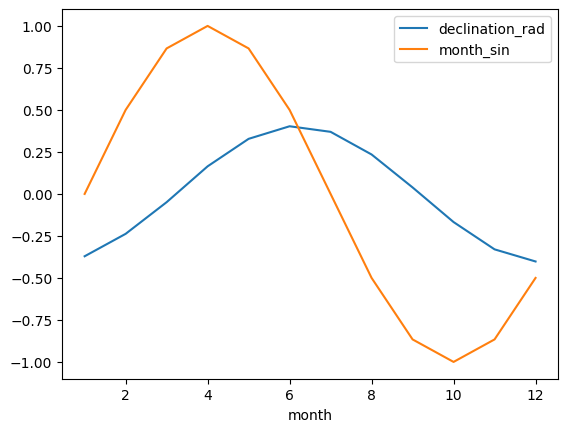

In [24]:
mid_month_doy = [15, 45, 74, 105, 135, 162, 198, 228, 258, 288, 318, 344]

# Function to calculate declination in degrees
def solar_declination(decl_day):
    return 23.44 * np.sin(np.deg2rad((360 / 365) * (decl_day - 81)))

def solar_declination_rad(decl_day):
    return np.deg2rad(23.44 * np.sin(np.deg2rad((360 / 365) * (decl_day - 81))))

# Create a DataFrame with month and declination
df_decl = pd.DataFrame({
    'month': np.arange(1, 13),
    'day_of_year': mid_month_doy
})
df_decl['declination_deg'] = df_decl['day_of_year'].apply(solar_declination)

# Optionally, include in radians
df_decl['declination_rad'] =  df_decl['day_of_year'].apply(solar_declination_rad)
df_decl['month_sin'] = df_decl['month'].apply(lambda month: np.sin(2 * np.pi * (month-1) / 12))
df_decl.plot(x='month', y=['declination_rad', 'month_sin'])

In [27]:
def get_day(month):
    mid_month_doy = {
        1: 15,
        2: 45,
        3: 74,
        4: 105,
        5: 135,
        6: 166,
        7: 196,
        8: 227,
        9: 258,
        10: 288,
        11: 319,
        12: 349}
    return mid_month_doy[int(month)]


In [38]:
for id in ids:
    df_year = pd.DataFrame()
    for season in range(1,13):
        df = pd.read_parquet(f"data/climate_features/{region}/predictor_{id}_{season}.parquet")
        season_string = f"0{season}" if season not in [10,11,12] else str(season)
        if df.index.dtype == "int64":
            df.index = pd.DatetimeIndex([f'{year}-{season_string}-01' for year in range(1972,2023)])
            df.index.name = "Date"
        df_year = pd.concat((df_year, df))
    df_year.sort_index(inplace=True)
    df_year['month'] = df_year.index.month
    df_year['day_of_year'] = df_year['month'].apply(get_day)
    df_year['solar_declination'] = df_year['day_of_year'].apply(solar_declination_rad)
    df_year.drop(columns=["month", "day_of_year"], inplace=True)
    df_year.to_parquet(f"data/climate_features/{region}/predictor_{id}_year_v2.parquet")
    print("Saved", id)
    
        

Saved 978f49d7
Saved 69ae08a8
Saved 1b939ac5
Saved 50a3f070
Saved 4d17ba1a
Saved 3adff093
Saved b33fc639
Saved 511854f2
Saved 9bd58418
Saved d7101242
Saved 3832cbd6
Saved 3df87a13
Saved 30ab9bad
Saved 311dd366
Saved 8c95fd00
Saved 9f8163e4
Saved 4effa258
Saved 13a24caf
Saved 8359c65d
Saved ecf2577f
Saved 458d357c


### California

In [39]:
region = "california"
metadata = pd.read_csv(f"data/climate_features/{region}/metadata.csv")
metadata

,id,filename,season,indices
0,6e47cb06,predictor_6e47cb06_1.parquet,1,df9a31c5-20a07cea-cfb03125-9169e0dc-0b0bffae-b...
1,6e47cb06,predictor_6e47cb06_2.parquet,2,df9a31c5-20a07cea-cfb03125-9169e0dc-0b0bffae-b...
2,6e47cb06,predictor_6e47cb06_3.parquet,3,df9a31c5-20a07cea-cfb03125-9169e0dc-0b0bffae-b...
3,6e47cb06,predictor_6e47cb06_4.parquet,4,df9a31c5-20a07cea-cfb03125-9169e0dc-0b0bffae-b...
4,6e47cb06,predictor_6e47cb06_5.parquet,5,df9a31c5-20a07cea-cfb03125-9169e0dc-0b0bffae-b...
5,6e47cb06,predictor_6e47cb06_6.parquet,6,df9a31c5-20a07cea-cfb03125-9169e0dc-0b0bffae-b...
6,6e47cb06,predictor_6e47cb06_7.parquet,7,df9a31c5-20a07cea-cfb03125-9169e0dc-0b0bffae-b...
7,6e47cb06,predictor_6e47cb06_8.parquet,8,df9a31c5-20a07cea-cfb03125-9169e0dc-0b0bffae-b...
8,6e47cb06,predictor_6e47cb06_9.parquet,9,df9a31c5-20a07cea-cfb03125-9169e0dc-0b0bffae-b...
9,6e47cb06,predictor_6e47cb06_10.parquet,10,df9a31c5-20a07cea-cfb03125-9169e0dc-0b0bffae-b...


In [40]:
ids = metadata["id"].unique()
ids

array(['6e47cb06', '5cb3fa02'], dtype=object)

In [41]:
for id in ids:
    df_year = pd.DataFrame()
    for season in range(1,13):
        df = pd.read_parquet(f"data/climate_features/{region}/predictor_{id}_{season}.parquet")
        season_string = f"0{season}" if season not in [10,11,12] else str(season)
        if df.index.dtype == "int64":
            df.index = pd.DatetimeIndex([f'{year}-{season_string}-01' for year in range(1972,2023)])
            df.index.name = "Date"
        df_year = pd.concat((df_year, df))
    df_year.sort_index(inplace=True)
    df_year['month'] = df_year.index.month
    df_year['day_of_year'] = df_year['month'].apply(get_day)
    df_year['solar_declination'] = df_year['day_of_year'].apply(solar_declination_rad)
    df_year.drop(columns=["month", "day_of_year"], inplace=True)
    df_year.to_parquet(f"data/climate_features/{region}/predictor_{id}_year_v2.parquet")
    print("Saved", id)
    
        

Saved 6e47cb06
Saved 5cb3fa02
